In [1]:
from itertools import product

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageOps

# Linear dimensionality reduction: Linear PCA
from sklearn.decomposition import PCA

# Non-linear dimensionality reduction: Kernel PCA
from sklearn.decomposition import KernelPCA

# DAISY feature extraction
from skimage.feature import daisy

# Pairwise distances for feature visualization
from sklearn.metrics.pairwise import pairwise_distances

matplotlib.rcParams.update({'figure.figsize': (15, 9)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})
%config InlineBackend.figure_format = 'retina'

sns.set_style("whitegrid")

In [2]:
image_size = (64, 64)

In [3]:
%%time

# the directory immediately under which all the images
# reside.
file_prefix = 'data/'

# The PIL flag for grayscale.
GRAYSCALE_MODE = 'L'

# Will store tuples (id,image_data,is_dog) and then
# will be converted into the DataFrame `images`.
images_list = []

# load data/cat.0.jpg to data/cat.499.jpg, 
# then data/dog.0.jpg to data/dog.499.jpg.
for pet_type, index in product(['cat', 'dog'], range(1000)):
    file_name = f'{pet_type}.{index}'
    
    # Load and convert to grayscale
    image = Image.open(f'{file_prefix}{file_name}.jpg').convert(mode=GRAYSCALE_MODE)
    
    # Aspect fit the image (shrink the image while maintaining
    # the aspect ratio such that the shorter dimension matches its target value
    # in image_size above. Then center it and crop off the excess to fit in
    # the dimensions of image_size).
    image = ImageOps.fit(image, image_size, method=Image.ANTIALIAS)
    
    # The PIL.ImageData object is essentially a matrix. Linearize it as a numpy array.
    data = np.asarray(image.getdata())/255
    
    # Add the boolean field `is_dog` as a simple representation of our cat/dog dichotomy.
    is_dog = (pet_type == 'dog')
    images_list.append((file_name,data,is_dog))

images = pd.DataFrame(data=images_list,columns=['id','image_data','is_dog'])

CPU times: user 15.9 s, sys: 568 ms, total: 16.4 s
Wall time: 17.5 s


In [4]:
images.head()

,id,image_data,is_dog
0,cat.0,"[0.8, 0.807843137255, 0.811764705882, 0.823529...",False
1,cat.1,"[0.16862745098, 0.156862745098, 0.164705882353...",False
2,cat.2,"[0.525490196078, 0.854901960784, 0.85490196078...",False
3,cat.3,"[0.537254901961, 0.447058823529, 0.46274509803...",False
4,cat.4,"[0.713725490196, 0.713725490196, 0.72549019607...",False


In [5]:
old_memory_usage = images.memory_usage(deep=True).sum()
# images.image_data = images.image_data.apply(lambda data: data.astype('uint8'))
# new_memory_usage = images.memory_usage(deep=True).sum()
print('Old size:',old_memory_usage/1000000.,'MB')
# print('New size:',new_memory_usage/1000000.,'MB')
# print('Savings of', 100.0*(old_memory_usage-new_memory_usage)/old_memory_usage, 'percent!')

Old size: 65.87386 MB


In [6]:
### SPLIT TRAIN TEST DATA
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images['image_data'], images['is_dog'], test_size=.2)
print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)
print('y_train shape', y_train.shape)
print('y_test shape', y_test.shape)

X_train shape (1600,)
X_test shape (400,)
y_train shape (1600,)
y_test shape (400,)


In [7]:
# [CITE] "04. Dimension Reduction and Images Notebook" by Eric Larson

def plot_gallery(imgs, titles, size, rows=3, cols=6):
    plt.figure(figsize = (1.7 * cols, 2.3 * rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    for i in range(rows * cols):
        plt.subplot(rows, cols, i+1)
        ax = plt.gca()
        [spine.set_color('black') for _,spine in ax.spines.items()]
        plt.imshow(imgs[i].reshape(size), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks([]); plt.yticks([])
    plt.show()

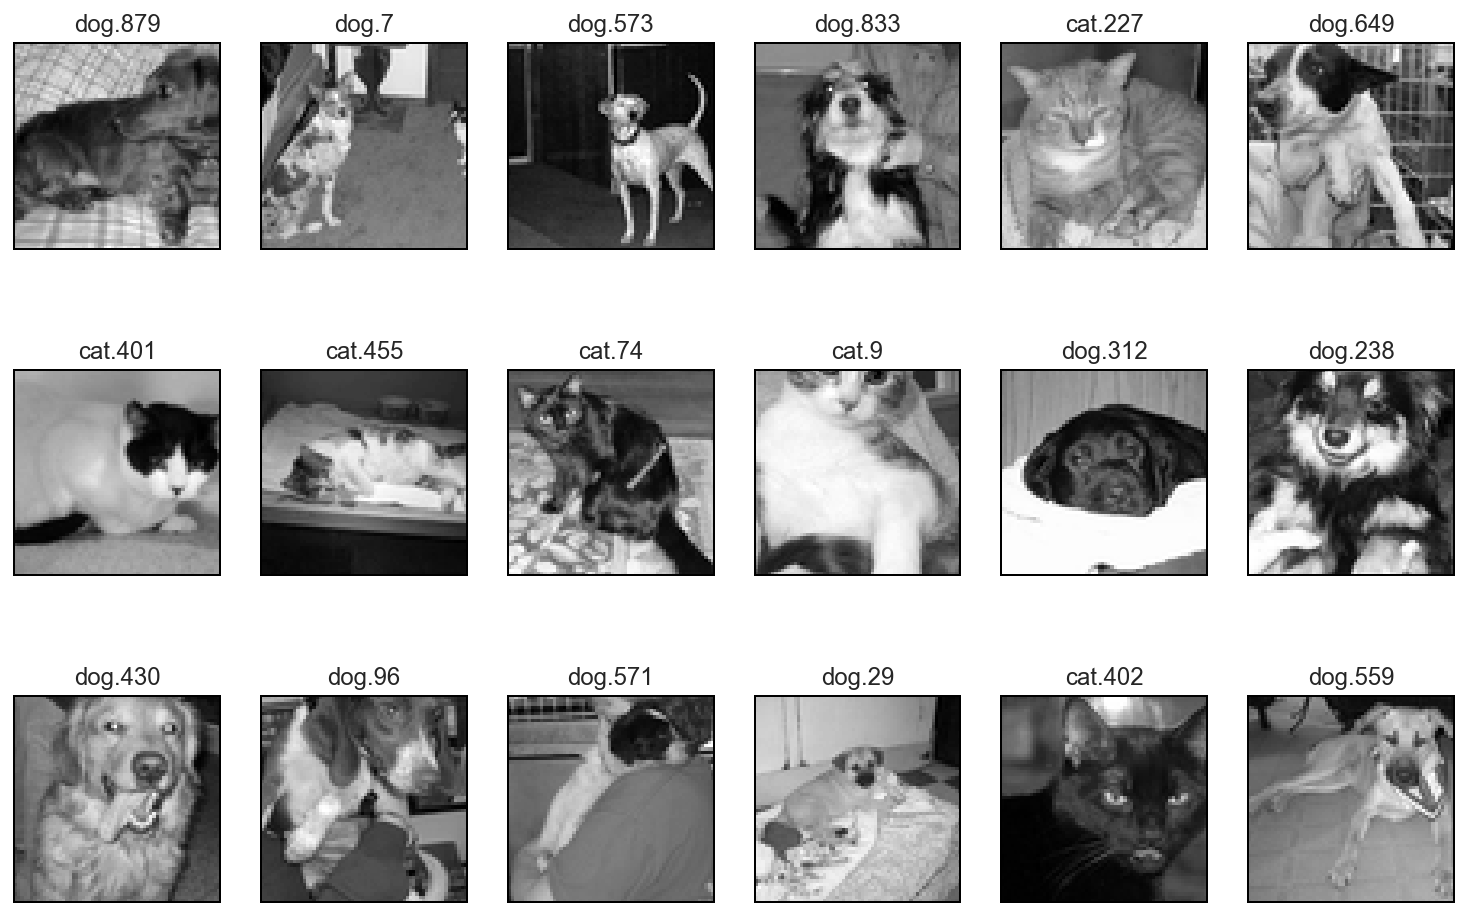

In [8]:
some_images = images.sample(n=18)
plot_gallery(some_images.image_data.iloc, some_images.id.iloc, image_size)

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D


class ConvolutionalNeuralNet:
    def __init__(
         self,
         input_shape=(64,64),
         filters_per_clayer=[16,16,16], 
         kernel_size=[(5,5),(2,2),(2,2)], 
         pool_size=(2,2),
         size_per_dlayer=[15,35],
         size_final_dlayer=2,
         convolution_dropout_rate=.25,
         dense_dropout_rate=.5,
         convolution_activation='relu',
         dense_activation='relu',
         final_activation='softmax'
    ):
        self.input_shape = input_shape;
        self.filters_per_clayer = filters_per_clayer
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.size_per_dlayer = size_per_dlayer
        self.size_final_dlayer = size_final_dlayer
        self.convolution_dropout_rate = convolution_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.convolution_activation = convolution_activation
        self.dense_activation = dense_activation
        self.final_activation = final_activation
    
    def _make_convolution_layers(self):
            
        if(len(self.filters_per_clayer) != len(self.kernel_size)):
            raise ValueError('The number of filters must equal the number of kernal sizes')
            
        self.model.add(Reshape((1,self.input_shape[0],self.input_shape[1]), 
                       input_shape=(1,self.input_shape[0]*self.input_shape[1])))
                       
        for i in range(len(self.filters_per_clayer)):
            if(
                int(self.input_shape[0]/(self.pool_size[0]*(i+1))) == 0 
            or 
                int(self.input_shape[1]/(self.pool_size[1]*(i+1))) == 0
            ):
                print("Warning: Size zero layer defined with input_shape (1,0,0). Reduce layer count")
                
            
            self.model.add(
                Conv2D(
                    filters=self.filters_per_clayer[i],
                    kernel_size=self.kernel_size[i],
                    padding='same',
                    activation=self.convolution_activation
                )
            )
            self.model.add(MaxPooling2D(pool_size=self.pool_size, data_format='channels_first'))
        
        self.model.add(Dropout(self.convolution_dropout_rate))
        self.model.add(Flatten())
                
    def _make_dense_layers(self):
        for size in self.size_per_dlayer:
            self.model.add(Dense(size, activation=self.dense_activation))
        self.model.add(Dropout(self.dense_dropout_rate))
        self.model.add(Dense(self.size_final_dlayer, activation=self.final_activation))
                
    def make_model(
        self, 
        loss='mean_squared_error', 
        optimizer='rmsprop', 
        metrics=['accuracy']
    ):
        self.model = Sequential()
        self._make_convolution_layers()
        self._make_dense_layers()
                
        self.model.compile(loss=loss,
                           optimizer=optimizer,
                           metrics=metrics)
                
    def fit(self, X, y_ohe,
            batch_size=32,
            epochs=150,
            shuffle=True,
            verbose=0
    ):
        X = np.matrix(X.tolist())
        X = np.expand_dims(X, axis=1)
        self.model.fit(X, y_ohe, 
                       batch_size=batch_size,
                       epochs=epochs,
                       shuffle=shuffle,
                       verbose=verbose)
                       
    def predict(self,X):
        X = np.matrix(X.tolist())
        X = np.expand_dims(X, axis=1)
        return self.model.predict(X)
    
    @staticmethod
    def one_hot_output(y_hat_raw):
        # predict() outputs floats. We want one-hot in most cases
        y_hat = np.zeros(y_hat_raw.shape, dtype=np.int)
        y_hat[np.arange(y_hat_raw.shape[0]), y_hat_raw.argmax(1)] = 1
        return y_hat

Using TensorFlow backend.
/Users/jake.rowland/.local/share/virtualenvs/Project7-vWKYM1JR/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [65]:
cnn = ConvolutionalNeuralNet(filters_per_clayer=[32, 64, 64, 16], 
                             kernel_size=[(5,5), (3,3), (3,3), (3,3)],
                             size_per_dlayer=[512, 64],
                             size_final_dlayer=2,
                             convolution_dropout_rate=.65,
                             dense_dropout_rate=.75,
                             dense_activation='relu')
cnn.make_model(
    loss='mean_squared_error', # 'categorical_crossentropy' 'mean_squared_error'
    optimizer='rmsprop', # 'adadelta' 'rmsprop'
)

In [73]:
%%time

y_ohe = np.asarray(pd.get_dummies(y_train))

cnn.fit(X_train, y_ohe, 
        batch_size=32,
        epochs=75,
        shuffle=False,
        verbose=1)

Epoch 1/75
1600/1600 [==============================] - 1s 762us/step - loss: 0.1267 - acc: 0.8312
Epoch 2/75
1600/1600 [==============================] - 1s 766us/step - loss: 0.1283 - acc: 0.8231
Epoch 3/75
1600/1600 [==============================] - 1s 761us/step - loss: 0.1240 - acc: 0.8350
Epoch 4/75
1600/1600 [==============================] - 1s 777us/step - loss: 0.1246 - acc: 0.8325
Epoch 5/75
1600/1600 [==============================] - 1s 763us/step - loss: 0.1227 - acc: 0.8438
Epoch 6/75
1600/1600 [==============================] - 1s 753us/step - loss: 0.1216 - acc: 0.8450
Epoch 7/75
1600/1600 [==============================] - 1s 767us/step - loss: 0.1391 - acc: 0.8150
Epoch 8/75
1600/1600 [==============================] - 1s 757us/step - loss: 0.1247 - acc: 0.8337
Epoch 9/75
1600/1600 [==============================] - 1s 755us/step - loss: 0.1155 - acc: 0.8500
Epoch 10/75
1600/1600 [==============================] - 1s 763us/step - loss: 0.1262 - acc: 0.8287
Epoch 11/

In [71]:
y_pred = cnn.predict(X_test).argmax(1)

[[ 0.58273381  0.41726619]
 [ 0.44827586  0.55172414]]


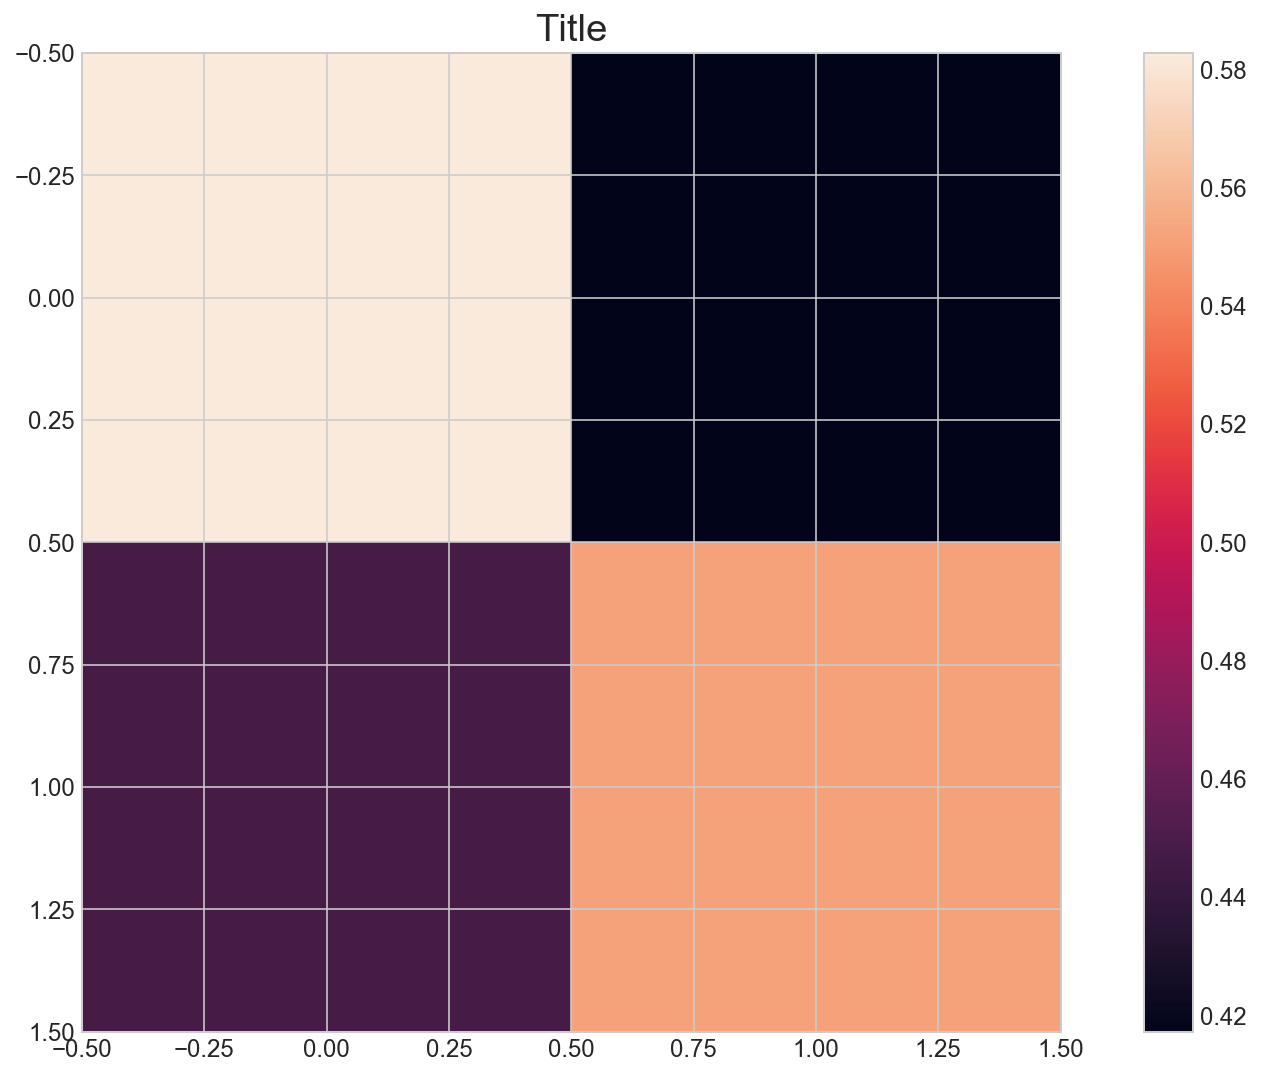

In [72]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred,y_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

plt.imshow(cm, interpolation='nearest')
plt.title('Title')
plt.colorbar()

plt.show()